In [20]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import  ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import  Dense # type: ignore
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # type: ignore

In [2]:
data = pd.read_parquet("../../Data/preprocessed/train_data_after_FE.parquet")

In [3]:
data.head()

,Store,Date,DayOfWeek,CompetitionDistance,CompetitionDistanceMissing,CompetitionOpenMissing,SchoolHoliday,Promo,Promo2,StoreType,...,Month_cos,IsWeekend,IsMonthEnd,IsMonthStart,OpenDuration,Promo2WeeksDuration,IsPromo2Month,DaysUntilNextStateHoliday,DaysSinceLastStateHoliday,DaysUntilClosed
Date_index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,2013-01-02,3,1270.0,False,False,1,False,False,c,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-03,1,2013-01-03,4,1270.0,False,False,1,False,False,c,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-04,1,2013-01-04,5,1270.0,False,False,1,False,False,c,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-05,1,2013-01-05,6,1270.0,False,False,1,False,False,c,...,0.866025,True,False,False,24,0,False,14,14,7
2013-01-07,1,2013-01-07,1,1270.0,False,False,1,True,False,c,...,0.866025,False,False,False,24,0,False,14,14,7


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   DayOfWeek                   844338 non-null  int8    
 2   CompetitionDistance         842152 non-null  float32 
 3   CompetitionDistanceMissing  844338 non-null  bool    
 4   CompetitionOpenMissing      844338 non-null  bool    
 5   SchoolHoliday               844338 non-null  int8    
 6   Promo                       844338 non-null  bool    
 7   Promo2                      844338 non-null  bool    
 8   StoreType                   844338 non-null  category
 9   Assortment                  844338 non-null  category
 10  Sales                       844338 non-null  float32 
 11  Year                        844338 non-null  int16   
 12  Month                       844338 non-null  int8 

In [4]:
data = data.drop(columns="Date")

In [21]:
standard_scale_features = [
    "CompetitionDistance",
    "OpenDuration",
    "Promo2WeeksDuration",
    "DaysUntilNextStateHoliday",
    "DaysSinceLastStateHoliday",
    "DaysUntilClosed",
    "SchoolHoliday",
    "Promo",
    "Promo2",
    "IsPromo2Month",
    "Year",
    "Month",
    "Day",
    "DayOfYear",
    "WeekOfYear",
    "Store",
    "DayOfWeek",
]

minmax_scale_features = ["DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos"]

boolean_features = [
    "CompetitionDistanceMissing",
    "CompetitionOpenMissing",
    "IsLastDayOfMonth",
    "IsWeekend",
    "IsMonthEnd",
    "IsMonthStart",
]

categorical_features_ohe = ["StoreType", "Assortment"]

numerical_features = standard_scale_features + boolean_features

In [22]:
standard_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
minmax_pipe = Pipeline(
    [("scaler", MinMaxScaler())]
)
cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("std_num", standard_pipe, numerical_features),
        ("minmax_cyc", minmax_pipe, minmax_scale_features),
        ("cat_ohe", cat_pipe, categorical_features_ohe),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

In [23]:
data.index = pd.to_datetime(data.index)
max_date = data.index.max()
split_date = max_date - pd.Timedelta(days=42)

train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()


X_train = train.drop(columns="Sales")
y_train = train.Sales
x_test = test.drop(columns="Sales")
y_test = test.Sales

print(X_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(804056, 29)
(804056,)
(40282, 29)
(40282,)


In [24]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(x_test)

In [ ]:
np.random.seed(42)
model_baseline = Sequential()
model_baseline.add(
    Dense(units=512, activation="relu", input_shape=(X_train_scaled.shape[1],)))
model_baseline.add(Dense(units=256, activation="relu"))
model_baseline.add(Dense(units=128, activation="relu"))
model_baseline.add(Dense(units=1))

model_baseline.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

model_baseline.summary()

print("\n--- Model Training ---")
history_baseline = model_baseline.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    verbose=1,
)

# 6. Model Evaluation
print("\n--- Baseline Evaluation ---")
loss_base, mae_base = model_baseline.evaluate(
    X_test_scaled, y_test, verbose=0
)
print(f"BASE Model Results on Test Set:")
print(f"Loss (MSE): {loss_base:.4f}")
print(f"MAE: {mae_base:.4f}")

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,273 (712.00 KB)

 Trainable params: 182,273 (712.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Model Training ---
Epoch 1/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - loss: 0.2043 - mae: 0.2975 - val_loss: 0.1034 - val_mae: 0.2490
Epoch 2/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 0.1043 - mae: 0.2499 - val_loss: 0.0893 - val_mae: 0.2292
Epoch 3/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 0.0840 - mae: 0.2220 - val_loss: 0.0943 - val_mae: 0.2374
Epoch 4/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.0714 - mae: 0.2027 - val_loss: 0.0705 - val_mae: 0.2007
Epoch 5/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0626 - mae: 0.1880 - val_loss: 0.0692 - val_mae: 0.1980
Epoch 6/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 0.0557 - mae: 0.1762 - val_loss: 0.0685 - val_mae: 0.1957
Epoch 7/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0511 - mae: 0.1678 - val_loss: 0.0606 - val_mae: 0.1826
Epoch 8/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 0.0473 - mae: 0.1605 - val_loss: 0.0668 - val_mae: 0.1985
Epoch 9/

In [30]:
y_predict = model_baseline.predict(X_test_scaled)
y_predict_flat = y_predict.flatten()

r2 = r2_score(y_test, y_predict_flat)

mse_sk = mean_squared_error(y_test, y_predict_flat)

print(f"\n--- Extended Evaluation (Scikit-learn) ---")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse_sk:.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_sk):.4f}")

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

--- Extended Evaluation (Scikit-learn) ---
R-squared (R2): 0.7398
Mean Squared Error (MSE): 0.0451
Root Mean Squared Error (RMSE): 0.2123


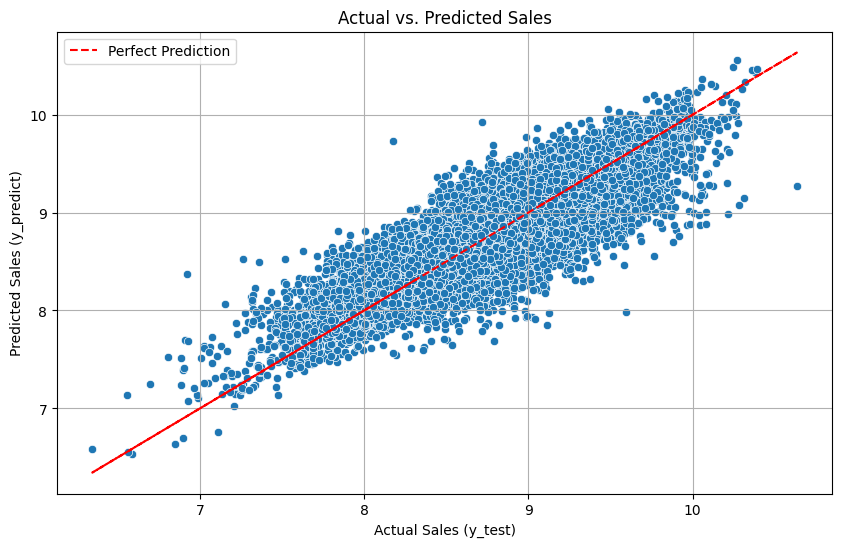

In [31]:
comparison_df = pd.DataFrame(
    {
        "Actual_Sales": y_test,
        "Predicted_Sales": y_predict.flatten(),  # Flatten to match y_test shape
    }
)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df["Actual_Sales"], y=comparison_df["Predicted_Sales"])
plt.plot(
    y_test, y_test, color="red", linestyle="--", label="Perfect Prediction"
)  # A line where Actual = Predicted
plt.title("Actual vs. Predicted Sales")
plt.xlabel("Actual Sales (y_test)")
plt.ylabel("Predicted Sales (y_predict)")
plt.legend()
plt.grid(True)
plt.show()